In [1]:
import numpy as np
import QuTFyP
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from math import pi
from awg_iq_simulator import pulses, awg_iq_emulator

In [2]:
measurement_records = {}

# Setting up the simulation: 
2-level system (qubit) @ 6.0 (GHz)

8-level system with no anharmonicity @ 9.5 (GHz) - the resonator

coupling via $\hat{x}_1\hat{x}_2$, coupling strength 0.1 (GHz)

resonator decays with rate 0.1 ($\mathrm{ns}^{-1}$)

resonator is pumped along "x" axis with amplitude 0.2
pump is rectangluar, time is 100 ns. monitoring time is 500 ns.

In [4]:
readout_power = 'strong'

In [3]:
qed = QuTFyP.TransmonQED()
rwa = True
qed.d = [2, 768] # one degree of freedom with two levels: a qubit
qed.rdtype_np = np.float32
qed.cdtype_np = np.complex64
qed.rdtype = tf.float32
qed.cdtype = tf.complex64
qed.ntraj = 200
qed.anharmonicities = [0.0, 0.0] #  anharmonicity is irrelevant for two-level systems
qed.frequencies = [2*pi*6.0, 2*pi*9.5] # in GHz. Transmon is 6.0, resonator is 9.5.
qed.couplings = [[0.0, 2*pi*0.1], [2*pi*0.1, 0.0]] # coupling constants between different degrees of freedom
qed.initialize_operators()
qed.minibatch = 200 # number of time steps with a single noise sample and without resampling
qed.simulation_time = 200.0
qed.dt = 0.005
qed.decoherences = {'resonator_decay':{'measurement_type':'homodyne',
                          'coupling_type':'a',
                          'rate':0.1,
                          'subsystem_id':1,
                          'record':True,
                          'unmix':True,
                          'unmix_reference':2*pi*9.5 if rwa else 0.,
                          'sample_rate':1.0,
                          'noise_spectral_density': np.ones((1,), dtype=qed.rdtype_np)}}

In [5]:
qed.expectations = { 'qubit_x': {'unmix':True,
                          'unmix_reference':2*pi*6. if rwa else 0., 
                          'sample_rate':1.,
            'observable_vec': lambda x,t: tf.real(qed.am_td_expect(x,t,ax=0)),
            'observable_mat': lambda x,t: tf.real(qed.am_td_expect(x,t,ax=0, mode='mat')) },
                          'qubit_y': {'unmix':True,
                          'unmix_reference':2*pi*6. if rwa else 0., 
                          'sample_rate':1.,
            'observable_vec': lambda x,t: tf.imag(qed.am_td_expect(x,t,ax=0)),
            'observable_mat': lambda x,t: tf.imag(qed.am_td_expect(x,t,ax=0, mode='mat')) },
                          'qubit_z': {'unmix':True,
                          'unmix_reference':2*pi*0., 
                          'sample_rate':1.,
            'observable_vec': lambda x,t: qed.observable(tf.real(tf.conj(x)*x*qed.multipliers_sqr_real[0])),
            'observable_mat': lambda x,t: qed.observable(tf.real(qed.multipliers_sqr_real[0]*x), mode='mat') },
                   'res_x': {'unmix':True,
                          'unmix_reference':2*pi*9.5 if rwa else 0., 
                          'sample_rate':1.,
            'observable_vec': lambda x,t: tf.real(qed.am_td_expect(x,t,ax=1)),
            'observable_mat': lambda x,t: tf.real(qed.am_td_expect(x,t,ax=1, mode='mat')) },
                          'res_y': {'unmix':True,
                          'unmix_reference':2*pi*9.5 if rwa else 0., 
                          'sample_rate':1.,
            'observable_vec': lambda x,t: tf.imag(qed.am_td_expect(x,t,ax=1)),
            'observable_mat': lambda x,t: tf.imag(qed.am_td_expect(x,t,ax=1, mode='mat')) },
                          'res_n': {'unmix':True,
                          'unmix_reference':2*pi*0., 
                          'sample_rate':1.,
            'observable_vec': lambda x,t: qed.observable(tf.real(tf.conj(x)*x*qed.multipliers_sqr_real[1])),
            'observable_mat': lambda x,t: qed.observable(tf.real(qed.multipliers_sqr_real[1]*x), mode='mat') }}

In [6]:
initial_state_type = 'ground'

In [7]:
qed.ntraj = 1
qed.initialize_operators()
if initial_state_type == 'superposition':
    gi = [[0,0,i] for i in range(qed.ntraj)]+[[1,0,i] for i in range(qed.ntraj)]  # A list of coordinates to update.
    gv = [np.sqrt(0.5)]*qed.ntraj*2  # A list of values corresponding to the respective
elif initial_state_type == 'excited':
    gi = [[1,0,i] for i in range(qed.ntraj)]  # A list of coordinates to update.
    gv = [np.sqrt(0.5)]*qed.ntraj  # A list of values corresponding to the respective
elif initial_state_type == 'ground':
    gi = [[0,0,i] for i in range(qed.ntraj)]  # A list of coordinates to update.
    gv = [np.sqrt(0.5)]*qed.ntraj  # A list of values corresponding to the respective
        # coordinate in indices.
qed.set_initial_pure_state(gi, gv)
#expectations_mat = qed.run('mat_pure') # master equation solution


qed.ntraj = 200
qed.initialize_operators()
if initial_state_type == 'superposition':
    gi = [[0,0,i] for i in range(qed.ntraj)]+[[1,0,i] for i in range(qed.ntraj)]  # A list of coordinates to update.
    gv = [np.sqrt(0.5)]*qed.ntraj*2  # A list of values corresponding to the respective
elif initial_state_type == 'excited':
    gi = [[1,0,i] for i in range(qed.ntraj)]  # A list of coordinates to update.
    gv = [np.sqrt(0.5)]*qed.ntraj  # A list of values corresponding to the respective
elif initial_state_type == 'ground':
    gi = [[0,0,i] for i in range(qed.ntraj)]  # A list of coordinates to update.
    gv = [np.sqrt(0.5)]*qed.ntraj  # A list of values corresponding to the respective
        # coordinate in indices.
qed.set_initial_pure_state(gi, gv, mat=False)

In [10]:
# Control signals
cutoff = 0.375
clock = 1
nop = 201
amplitude = 1
p = pulses(channels={'ro': awg_iq_emulator(clock, cutoff, nop, amplitude)})
#drive_amplitudes = np.linspace(0, 50, ntraj)
#drive_amplitudes = 1.
#drive_frequencies = 2*pi*9.5
#ro_amplitude = 0.2 if readout_power=='medium' else 0.04 if readout_power=='weak' else 0.5
ro_amplitudes = np.linspace(0, 0.4, 21)

e = []; m = [];

for sweep_id, ro_amplitude in enumerate(ro_amplitudes):
    qed.controls = {'ro_x':{'carrier':2*pi*9.5, 'phi':0,        'coupling':[{}, {'y':-1}], 'envelope':p.channels['ro'].get_x},
                'ro_y':{'carrier':2*pi*9.5, 'phi':np.pi/2., 'coupling':[{}, {'x': 1}], 'envelope':p.channels['ro'].get_y}}
    seq = [{'ro':p.rect('ro', 100.0, ro_amplitude)}, {'ro':p.pause('ro', 100.0)}]
    p.set_seq(seq)
    p.channels['ro'].resample_waveform(qed.dt/2.)
    
    _e, _m = qed.run('vec') # run homodyne solution
    e.append(_e)
    m.append(_m)

homodyne
homodyne
homodyne
homodyne



100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [39:08<00:00, 17.03it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [48:48<00:00, 13.66it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [53:38<00:00, 23.19it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [27:59<00:00, 23.10it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [28:27<00:00, 23.43it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [31:29<00:00, 11.38it/s]


homodyne
homodyne
homodyne
homodyne


100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [1:14:23<00:00,  8.96it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [32:12<00:00, 20.70it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [34:26<00:00, 19.36it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [28:37<00:00, 23.30it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [28:04<00:00, 23.75it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [27:57<00:00, 23.21it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [27:52<00:00, 24.62it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [27:56<00:00, 23.88it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [27:46<00:00, 22.68it/s]


homodyne
homodyne
homodyne
homodyne


100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [28:07<00:00, 24.10it/s]


KeyboardInterrupt: 

In [12]:
import pickle

In [15]:
pickle.dump?

In [16]:
with open('Glebs-tumor-em.pkl', 'wb') as f:
    pickle.dump(e, f)
    pickle.dump(m, f)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


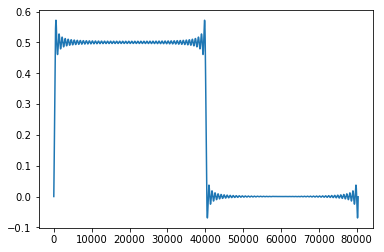

In [59]:
plt.plot(p.channels['ro'].resampled_waveform)
plt.show()

In [62]:
measurement_records[initial_state_type] = measurements_vec_homodyne

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


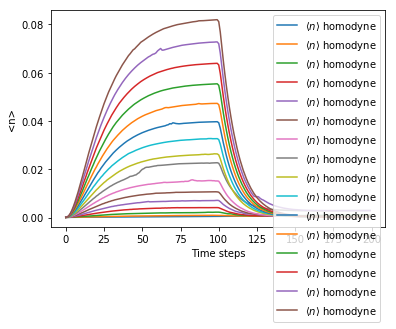

In [17]:
#plt.plot(expectations_mat['qubit_x'][:, 0])
#plt.plot(expectations_mat['qubit_y'][:, 0])
tax = np.arange(0, qed.simulation_time, 1/qed.expectations['qubit_z']['sample_rate'])
gamma_pur = qed.couplings[0][1]**2*qed.decoherences['resonator_decay']['rate']/(qed.frequencies[1]-qed.frequencies[0])**2
gamma = qed.decoherences['resonator_decay']['rate']
###plt.plot(tax, expectations_mat['qubit_z'][:, 0], label='$\\langle n \\rangle$ ME')
for i, expectations_vec_homodyne in enumerate(e):
    plt.plot(tax, np.mean(expectations_vec_homodyne['qubit_z'], axis=1), label='$\\langle n \\rangle$ homodyne')
#plt.plot(tax, np.exp(-tax*gamma_pur), label='$\\langle n \\rangle$ Purcell')
#plt.plot(tax, np.exp(-tax*gamma), label='$\\langle n \\rangle$ direct')
plt.legend()
plt.xlabel('Time steps')
plt.ylabel('<n>')
plt.savefig('Purcell {} {}.png'.format(initial_state_type, readout_power))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


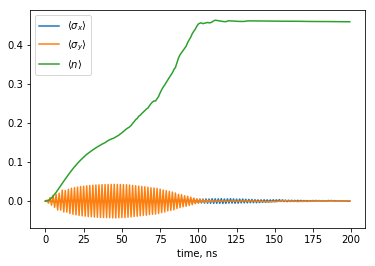

In [64]:
plt.plot(tax, np.mean(expectations_vec_homodyne['qubit_x'][:, :], axis=1), label='$\langle \\sigma_x \\rangle$')
plt.plot(tax, np.mean(expectations_vec_homodyne['qubit_y'][:, :], axis=1), label='$\langle \\sigma_y \\rangle$')
plt.plot(tax, np.mean(expectations_vec_homodyne['qubit_z'][:, :], axis=1), label='$\langle n \\rangle$')
plt.xlabel('time, ns')
plt.legend()
plt.savefig('Qubit state {} {}.png'.format(initial_state_type, readout_power))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


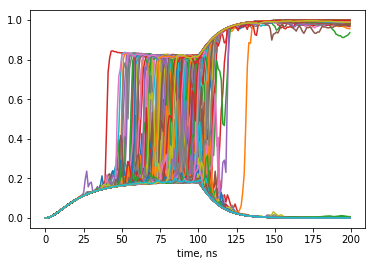

In [65]:
plt.plot(tax, expectations_vec_homodyne['qubit_z'][:, :], label='$\langle n \\rangle$')
plt.xlabel('time, ns')
#plt.legend()
plt.savefig('Qubit state trajectories {} {}.png'.format(initial_state_type, readout_power))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


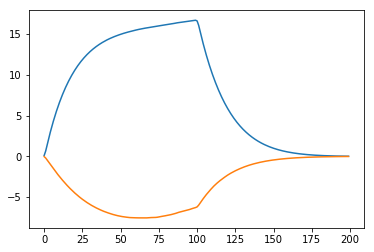

In [66]:
#plt.plot(expectations_vec_homodyne['res_x'][:, 0])
#plt.plot(expectations_vec_homodyne['res_y'][:, 0])
plt.plot(tax, np.mean(expectations_vec_homodyne['res_x'][:, :], axis=1))
plt.plot(tax, np.mean(expectations_vec_homodyne['res_y'][:, :], axis=1))
###plt.plot(tax, expectations_mat['res_x'][:, 0])
###plt.plot(tax, expectations_mat['res_y'][:, 0])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


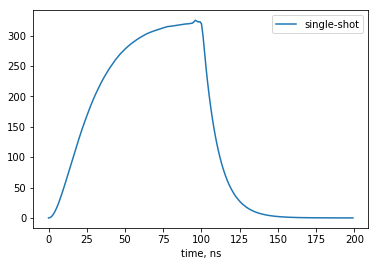

In [67]:
#plt.plot(expectations_vec_homodyne['res_x'][:, 0])
#plt.plot(expectations_vec_homodyne['res_y'][:, 0])
plt.plot(tax, expectations_vec_homodyne['res_n'][:, 0], label='single-shot')
###plt.plot(tax, expectations_mat['res_n'][:, 0], label='average')
plt.xlabel('time, ns')
plt.legend()
plt.savefig('Resonator population {} {}.png'.format(initial_state_type, readout_power))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


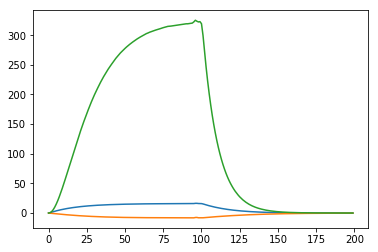

In [68]:
plt.plot(tax, expectations_vec_homodyne['res_x'][:, 0])
plt.plot(tax, expectations_vec_homodyne['res_y'][:, 0])
plt.plot(tax, expectations_vec_homodyne['res_n'][:, 0])
plt.show()

In [69]:
plt.plot(tax, expectations_mat['res_x'][:, 0])
plt.plot(tax, expectations_mat['res_y'][:, 0])
plt.plot(tax, expectations_mat['res_n'][:, 0])
plt.show()

NameError: name 'expectations_mat' is not defined

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


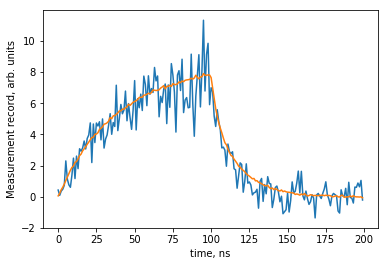

In [70]:
plt.plot(tax, measurements_vec_homodyne['resonator_decay'][:,0], label='single-shot')
plt.plot(tax, np.mean(measurements_vec_homodyne['resonator_decay'], axis=1), label='averaged')
plt.xlabel('time, ns')
plt.ylabel('Measurement record, arb. units')
plt.savefig('Dispersive readout signal averaged {} {}.png'.format(initial_state_type, readout_power))
plt.show()

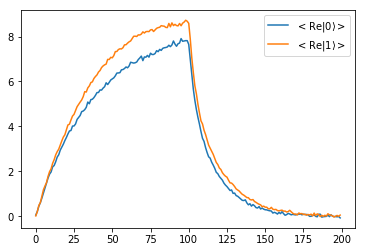

In [71]:

#plt.plot(np.real(measurement_records['ground']['resonator_decay'][:,0]), label='$\\operatorname{Re} |0 \\rangle$ SS')
#plt.plot(np.real(measurement_records['excited']['resonator_decay'][:,0]), label='$\\operatorname{Re} |1 \\rangle$ SS')
plt.plot(np.real(np.mean(measurement_records['ground']['resonator_decay'], axis=1)), label='$<\\operatorname{Re} |0 \\rangle>$')
#plt.plot(np.real(np.mean(measurement_records['superposition']['resonator_decay'], axis=1)))
plt.plot(np.real(np.mean(measurement_records['excited']['resonator_decay'], axis=1)), label='$<\\operatorname{Re} |1 \\rangle>$')
plt.legend()
plt.savefig('AVG sample real {}.png'.format(readout_power))
plt.show()

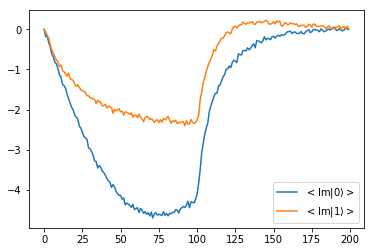

In [72]:
plt.plot(np.imag(np.mean(measurement_records['ground']['resonator_decay'], axis=1)), label='$<\\operatorname{Im} |0 \\rangle>$')
#plt.plot(np.imag(np.mean(measurement_records['superposition']['resonator_decay'], axis=1)))
plt.plot(np.imag(np.mean(measurement_records['excited']['resonator_decay'], axis=1)), label='$<\\operatorname{Im} |1 \\rangle>$')
plt.legend()
plt.savefig('AVG sample imag {}.png'.format(readout_power))
plt.show()

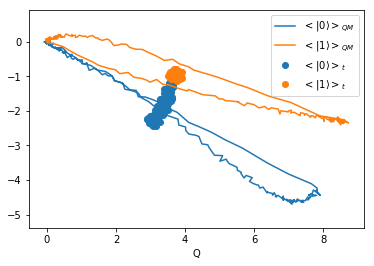

In [73]:
plt.plot(np.real(np.mean(measurement_records['ground']['resonator_decay'], axis=1)),
         np.imag(np.mean(measurement_records['ground']['resonator_decay'], axis=1)), 
         label='$<|0 \\rangle>_{QM}$')
plt.plot(np.real(np.mean(measurement_records['excited']['resonator_decay'], axis=1)),
         np.imag(np.mean(measurement_records['excited']['resonator_decay'], axis=1)), 
         label='$<|1 \\rangle>_{QM}$')

plt.scatter(np.real(np.mean(measurement_records['ground']['resonator_decay'], axis=0)),
         np.imag(np.mean(measurement_records['ground']['resonator_decay'], axis=0)), 
         label='$<|0 \\rangle>_t$')
plt.scatter(np.real(np.mean(measurement_records['excited']['resonator_decay'], axis=0)),
         np.imag(np.mean(measurement_records['excited']['resonator_decay'], axis=0)), 
         label='$<|1 \\rangle>_t$')

plt.xlabel('I')
plt.xlabel('Q')
plt.legend()
plt.axis('equal')
plt.savefig('AVG sample IQ {}.png'.format(readout_power))
plt.show()

In [74]:
# constructing linear classifier
avg = 0.5*(np.mean(measurement_records['excited']['resonator_decay'], axis=1)+\
           np.mean(measurement_records['ground']['resonator_decay'], axis=1))
diff = 0.5*(np.mean(measurement_records['ground']['resonator_decay'], axis=1)-\
            np.mean(measurement_records['excited']['resonator_decay'], axis=1))
diff = diff/np.sum(np.abs(diff)**2)

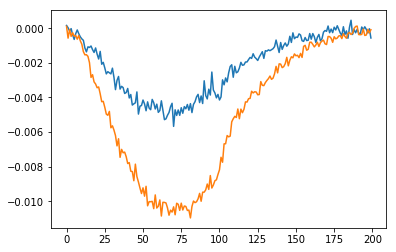

In [75]:
plt.plot(tax, np.real(diff))
plt.plot(tax, np.imag(diff))
plt.show()

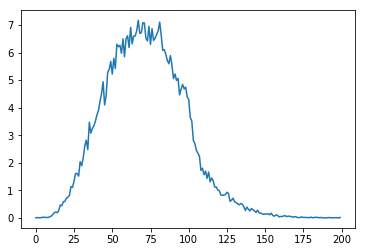

In [76]:
plt.plot(tax, np.abs(np.mean(measurement_records['ground']['resonator_decay'], axis=1)-\
                     np.mean(measurement_records['excited']['resonator_decay'], axis=1))**2)
plt.show()

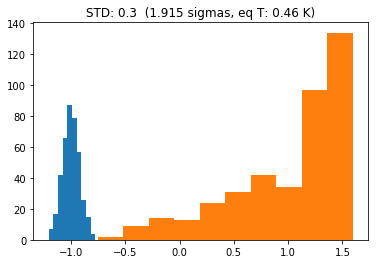

In [77]:
from scipy.special import erf
from scipy.constants import Boltzmann, hbar
plt.hist(np.real(np.sum(np.conj(diff)*(measurement_records['excited']['resonator_decay'].T-avg), axis=1)))
plt.hist(np.real(np.sum(np.conj(diff)*(measurement_records['ground']['resonator_decay'].T-avg), axis=1)))
std0=np.real(np.sum(np.conj(diff)*(measurement_records['ground']['resonator_decay'].T-avg), axis=1))
std1=np.real(np.sum(np.conj(diff)*(measurement_records['excited']['resonator_decay'].T-avg), axis=1))
noise_equivalant = hbar*qed.frequencies[1]/Boltzmann*1e9
title = 'STD: '+str(np.round(0.5*(np.std(std0)+np.std(std1)), 3))+'  ({0} sigmas, eq T: {1:4.2} K)'.format(np.round(1./np.std(std0), 3),noise_equivalant)
plt.title(title)
plt.savefig('Separation fidelity {}.png'.format(readout_power))
plt.show()
#print ('STD |0>: ', np.std(std0), ' STD |1>: ', np.std(std1))
#print ('Separation infidelity: ', (erf(-1./np.std(std0))+1)/2., '({} sigmas)'.format(1./np.std(std0)))